<a href="https://colab.research.google.com/github/mish841/RAISE-26-Data-Science-AI-Competition-Submission/blob/mishal-phase2-progress/data_science_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries and load dataset of 10500 AI related articles.

In [78]:
import pandas as pd
import nltk
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize



DATA_PATH = "dataset_A_news_full_10500.csv"
# df = pd.read_csv("dataset_A_news_full_10500.csv")


df = pd.read_csv(DATA_PATH)

df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,title,link,date,source,number_of_characters_title,number_of_words_title,day_of_week,month,year,quarter,is_weekend,classes_str
0,Google’s AI is the ‘worst’ for stealing conten...,https://news.google.com/rss/articles/CBMipgFBV...,2025-09-11,Fortune,74,13,Thursday,September,2025,3,False,Sentiment (Positive / Negative Feelings); Huma...
1,Powering the Next Wave of Enterprise Innovatio...,https://news.google.com/rss/articles/CBMitgFBV...,2025-09-11,Silicon Canals,106,16,Thursday,September,2025,3,False,"Creativity, Expression & Identity; Work, Jobs ..."
2,AI a ‘strategic necessity’ law lecturer says,https://news.google.com/rss/articles/CBMiiAFBV...,2025-09-11,qlsproctor.com.au,64,9,Thursday,September,2025,3,False,"Society, Ethics & Culture"
3,Datacom sees AI agents as pivotal to legacy ap...,https://news.google.com/rss/articles/CBMirAFBV...,2025-09-11,ARNnet,70,12,Thursday,September,2025,3,False,"Routine, Lifestyle & Behavior"
4,"Student Blog: Startups, AI, and Lessons from S...",https://news.google.com/rss/articles/CBMijwFBV...,2025-09-11,The University of Queensland,85,13,Thursday,September,2025,3,False,"Learning, Knowledge & Education"


Checks for missing values and converts the date column to datetime format for temporal analysis

In [79]:
df.info()
df.isna().sum().sort_values(ascending=False).head(20)
# After loading the data
df['date'] = pd.to_datetime(df['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       10500 non-null  object
 1   link                        10500 non-null  object
 2   date                        10500 non-null  object
 3   source                      10500 non-null  object
 4   number_of_characters_title  10500 non-null  int64 
 5   number_of_words_title       10500 non-null  int64 
 6   day_of_week                 10500 non-null  object
 7   month                       10500 non-null  object
 8   year                        10500 non-null  int64 
 9   quarter                     10500 non-null  int64 
 10  is_weekend                  10500 non-null  bool  
 11  classes_str                 10500 non-null  object
dtypes: bool(1), int64(4), object(7)
memory usage: 912.7+ KB


Class Frequency: Analyzes how frequently different content categories appear. Each article can have multiples categories seperated by semicolons.

In [80]:
all_classes = []
for classes_str in df['classes_str']:
    classes = [c.strip() for c in str(classes_str).split(';')]
    all_classes.extend(classes)

# Count occurrences
class_counts = Counter(all_classes)

# Convert to DataFrame
class_df = pd.DataFrame(
    class_counts.items(),
    columns=['class', 'count']
).sort_values('count', ascending=False).reset_index(drop=True)

class_df.head(15)

,class,count
0,"Work, Jobs & Economy",2526
1,"Learning, Knowledge & Education",1946
2,Technology & Interaction,1733
3,"Society, Ethics & Culture",1584
4,"Routine, Lifestyle & Behavior",1479
5,Sentiment (Positive / Negative Feelings),1441
6,Human Roles,1256
7,"Health, Safety & Risk",1230
8,"Creativity, Expression & Identity",877
9,Cognitive & Decision-Making,832


Domain article frequency: Creates binary indicator columns and mark which domain category is present in each article.

In [81]:
# Create boolean columns for ALL 12 categories using EXACT names
df['is_sentiment'] = df['classes_str'].apply(lambda x: 'Sentiment (Positive / Negative Feelings)' in x)
df['is_emotion'] = df['classes_str'].apply(lambda x: 'Emotion, Motivation & Well-being' in x)
df['is_human_roles'] = df['classes_str'].apply(lambda x: 'Human Roles' in x)
df['is_behavior'] = df['classes_str'].apply(lambda x: 'Routine, Lifestyle & Behavior' in x)
df['is_cognitive'] = df['classes_str'].apply(lambda x: 'Cognitive & Decision-Making' in x)
df['is_creativity'] = df['classes_str'].apply(lambda x: 'Creativity, Expression & Identity' in x)
df['is_relationships'] = df['classes_str'].apply(lambda x: 'Social Interaction & Relationships' in x)
df['is_work'] = df['classes_str'].apply(lambda x: 'Work, Jobs & Economy' in x)
df['is_education'] = df['classes_str'].apply(lambda x: 'Learning, Knowledge & Education' in x)
df['is_health'] = df['classes_str'].apply(lambda x: 'Health, Safety & Risk' in x)
df['is_society'] = df['classes_str'].apply(lambda x: 'Society, Ethics & Culture' in x)
df['is_technology'] = df['classes_str'].apply(lambda x: 'Technology & Interaction' in x)



In [82]:

domain_map = {
    'Sentiment (Positive / Negative Feelings)': 'is_sentiment',
    'Emotion, Motivation & Well-being': 'is_emotion',
    'Human Roles': 'is_human_roles',
    'Routine, Lifestyle & Behavior': 'is_behavior',
    'Cognitive & Decision-Making': 'is_cognitive',
    'Creativity, Expression & Identity': 'is_creativity',
    'Social Interaction & Relationships': 'is_relationships',
    'Work, Jobs & Economy': 'is_work',
    'Learning, Knowledge & Education': 'is_education',
    'Health, Safety & Risk': 'is_health',
    'Society, Ethics & Culture': 'is_society',
    'Technology & Interaction': 'is_technology'
}

print("\nKey Research Domain Counts:")

for label, col in domain_map.items():
    count = df[col].sum()
    percentage = (count / len(df)) * 100
    print(f"{label:40} {count:5} articles ({percentage:5.1f}%)")



Key Research Domain Counts:
Sentiment (Positive / Negative Feelings)  1441 articles ( 13.7%)
Emotion, Motivation & Well-being           551 articles (  5.2%)
Human Roles                               1256 articles ( 12.0%)
Routine, Lifestyle & Behavior             1479 articles ( 14.1%)
Cognitive & Decision-Making                832 articles (  7.9%)
Creativity, Expression & Identity          877 articles (  8.4%)
Social Interaction & Relationships         730 articles (  7.0%)
Work, Jobs & Economy                      2526 articles ( 24.1%)
Learning, Knowledge & Education           1946 articles ( 18.5%)
Health, Safety & Risk                     1230 articles ( 11.7%)
Society, Ethics & Culture                 1584 articles ( 15.1%)
Technology & Interaction                  1733 articles ( 16.5%)


Defining Seed Words: Creates emotion dictionaries by starting with seed words and expanding them using synonyms from WordNet. This creates comprehensive lists of emotion related words to search for in headlines.

In [83]:
seed_emotions = {
    'fear': ['fear', 'threat', 'danger'],
    'anxiety': ['anxiety', 'worry', 'uncertainty'],
    'optimism': ['hope', 'opportunity', 'promise'],
    'trust': ['trust', 'confidence', 'reliability']
}

def expand_emotion_words(seed_list):
    words = set(seed_list)
    for seed in seed_list:
        for syn in wn.synsets(seed):
            for lemma in syn.lemmas():
                words.add(lemma.name().lower().replace('_', ' '))
    return words

emotion_buckets = {
    emotion: expand_emotion_words(seeds)
    for emotion, seeds in seed_emotions.items()
}


Function counts how many emotion-related words appear in each headline, creating numerical scores for fear, anxiety, optimism, and trust.

In [84]:
def count_emotion_words(text, word_list):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return sum(word in text for word in word_list)

emotion = pd.DataFrame()
emotion['title'] = df['title']
emotion['fear_score'] = df['title'].apply(lambda x: count_emotion_words(x, emotion_buckets['fear']))
emotion['anxiety_score'] = df['title'].apply(lambda x: count_emotion_words(x, emotion_buckets['anxiety']))
emotion['optimism_score'] = df['title'].apply(lambda x: count_emotion_words(x, emotion_buckets['optimism']))
emotion['trust_score'] = df['title'].apply(lambda x: count_emotion_words(x, emotion_buckets['trust']))

emotion.head(15)

,title,fear_score,anxiety_score,optimism_score,trust_score
0,Google’s AI is the ‘worst’ for stealing conten...,0,0,0,0
1,Powering the Next Wave of Enterprise Innovatio...,0,0,0,0
2,AI a ‘strategic necessity’ law lecturer says,0,0,0,0
3,Datacom sees AI agents as pivotal to legacy ap...,0,0,0,0
4,"Student Blog: Startups, AI, and Lessons from S...",0,0,0,0
5,PwC Australia launches agentic AI professional...,0,0,0,0
6,Content database specialist Giata Group acquir...,0,0,0,0
7,Is Donald Trump's video on Charlie Kirk's shoo...,0,0,0,0
8,China chipmaking stocks rally tracking Oracle-...,0,0,0,0
9,Klarna 'course-correct' after aggressive AI ad...,0,0,0,0


Provides statistical summary of emotion scores across all articles.

In [85]:
emotion[['fear_score','anxiety_score','optimism_score','trust_score']].describe()


,fear_score,anxiety_score,optimism_score,trust_score
count,10500.000000,10500.000000,10500.000000,10500.000000
mean,0.111619,0.051905,0.064571,0.044857
std,0.325619,0.223982,0.251904,0.222523
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,3.000000


Analyzes how emotional framing in AI news headlines changes over months throughout 2025. Creates vizualization showing temporal emotion trends.

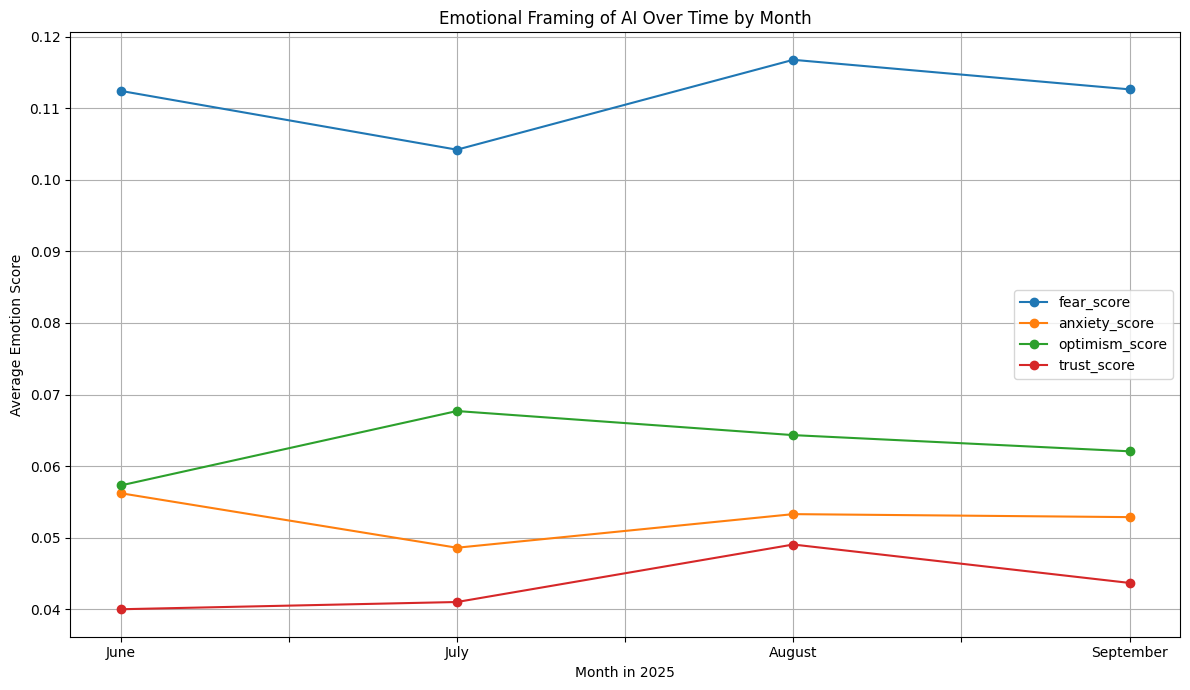

,fear_score,anxiety_score,optimism_score,trust_score
month,,,,
January,NaN,NaN,NaN,NaN
February,NaN,NaN,NaN,NaN
March,NaN,NaN,NaN,NaN
April,NaN,NaN,NaN,NaN
May,NaN,NaN,NaN,NaN
June,0.112432,0.056216,0.057297,0.040000
July,0.104213,0.048596,0.067697,0.041011
August,0.116773,0.053291,0.064331,0.049045
September,0.112644,0.052874,0.062069,0.043678


In [86]:
emotion['year'] = df['year']
emotion['month'] = df['month']

#Aggregate by month since the year is 2025 for all headlines
emotion_by_month = emotion.groupby('month')[
    ['fear_score','anxiety_score','optimism_score','trust_score']
].mean()

# Order months chronologically for plotting
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
emotion_by_month = emotion_by_month.reindex(month_order)


import matplotlib.pyplot as plt

#plot trends
emotion_by_month.plot(
    figsize=(12,7),
    title='Emotional Framing of AI Over Time by Month',
    marker='o' # Add markers for better visibility of data points
)
plt.xlabel('Month in 2025')
plt.ylabel('Average Emotion Score')
plt.grid(True)
plt.tight_layout()
plt.show()

emotion_by_month


*   Fear (blue) is the dominant
emotion, consistently around 0.10 - 0.12.
Peaks in August (0.117) - highest fear period
*   Optimism (green) is the second highest, ranging from 0.06 - 0.07.
Peaks in July (0.068)

*  Anxiety (orange) stays relatively stable approx 0.05.
Slight increase in August
*  Trust (red) is the lowest emotion, around 0.04 - 0.05


Interpretation: AI news coverage is predominantly fear-focused rather than optimistic, with trust being notably low throughout the summer.





TF-IDF Vectorization and Setup


In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

# Create output directory
OUTPUT_DIR = 'analysis_outputs'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"✓ Created output directory: {OUTPUT_DIR}")

# TF-IDF Vectorization
print("\n" + "=" * 80)
print("TF-IDF VECTORIZATION")
print("=" * 80)

tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),  # Include bigrams
    min_df=5,  # Ignore rare terms
    max_df=0.8  # Ignore common terms
)

X_tfidf = tfidf.fit_transform(emotion['title'])  # Using your emotion DataFrame

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Total features extracted: {len(tfidf.get_feature_names_out())}")
print(f"\n✓ TF-IDF vectorization complete!")



TF-IDF VECTORIZATION
TF-IDF matrix shape: (10500, 1000)
Total features extracted: 1000

✓ TF-IDF vectorization complete!


Topic Modeling with KMeans




Calculating optimal number of clusters...


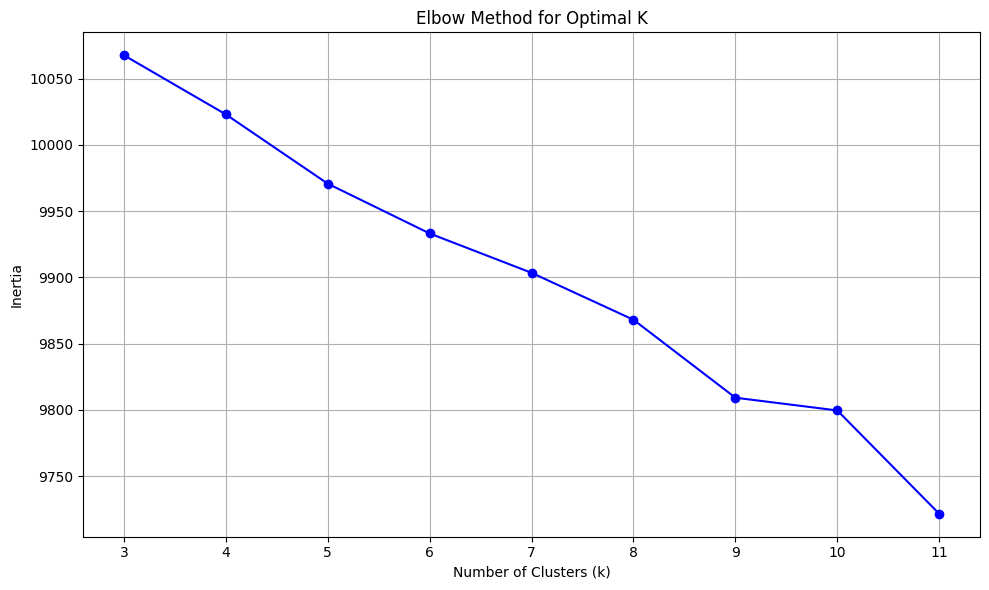

✓ Saved: analysis_outputs/elbow_curve.png

Using 6 clusters

Topic distribution:
topic_cluster
0     567
1    1671
2     251
3    7591
4     195
5     225
Name: count, dtype: int64


In [88]:


inertias = []
K_range = range(3, 12)

print("\nCalculating optimal number of clusters...")
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_tfidf)
    inertias.append(kmeans_temp.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/elbow_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {OUTPUT_DIR}/elbow_curve.png")

# Use 6 clusters (you can adjust based on elbow curve)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['topic_cluster'] = kmeans.fit_predict(X_tfidf)

print(f"\nUsing {n_clusters} clusters")
print(f"\nTopic distribution:")
print(df['topic_cluster'].value_counts().sort_index())

Extract Top Keywords per Topic: Identifies the 10 most characteristic words for each topic cluster, helping understand what each cluster is about.


In [89]:
print("\n" + "=" * 80)
print("TOPIC CHARACTERIZATION - TOP KEYWORDS")
print("=" * 80)

feature_names = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

topic_keywords = {}

for i in range(n_clusters):
    top_terms = [feature_names[ind] for ind in order_centroids[i, :10]]
    topic_keywords[i] = top_terms
    print(f"\nTopic {i}:")
    print(f"  Keywords: {', '.join(top_terms)}")

    # Get sample headlines from this topic
    topic_data = df[df['topic_cluster'] == i]
    print(f"  Size: {len(topic_data)} articles ({len(topic_data)/len(df)*100:.1f}%)")
    print(f"  Sample headlines:")
    for idx, title in enumerate(topic_data.sample(min(2, len(topic_data)))['title'].values, 1):
        print(f"    {idx}. {title}")




TOPIC CHARACTERIZATION - TOP KEYWORDS

Topic 0:
  Keywords: new, new ai, new study, study, tool, tools, ai tool, use, ai new, report
  Size: 567 articles (5.4%)
  Sample headlines:
    1. Towards a new generation of human AI collaboration
    2. Meta implements new rules for its AI after disturbing child safety report: 'We’re adding more guardrails as an extra precaution'

Topic 1:
  Keywords: artificial, artificial intelligence, intelligence, intelligence ai, prediction, technology, university, use, education, analysis
  Size: 1671 articles (15.9%)
  Sample headlines:
    1. The American Federal Reserve reveals that artificial intelligence has not weakened employment so far
    2. St. Thomas University Unveils 7 Standards for Ethical Use of Artificial Intelligence

Topic 2:
  Keywords: using, using ai, guide using, complete guide, guide, complete, using generative, industry, 2025, work
  Size: 251 articles (2.4%)
  Sample headlines:
    1. The academics taking on ‘cheating’ students 

Emotion Profiles by Topic:  Creates a heatmap showing which emotions are most prevalent in each topic cluster, revealing the emotional character of different AI news topics.


INTEGRATED ANALYSIS: EMOTION PROFILES BY TOPIC

Average emotion scores by topic:
               fear_score  anxiety_score  optimism_score  trust_score
topic_cluster                                                        
0                   0.101          0.044           0.060        0.060
1                   0.098          0.056           0.099        0.033
2                   0.120          0.060           0.032        0.044
3                   0.118          0.052           0.060        0.047
4                   0.092          0.046           0.036        0.041
5                   0.036          0.018           0.040        0.031


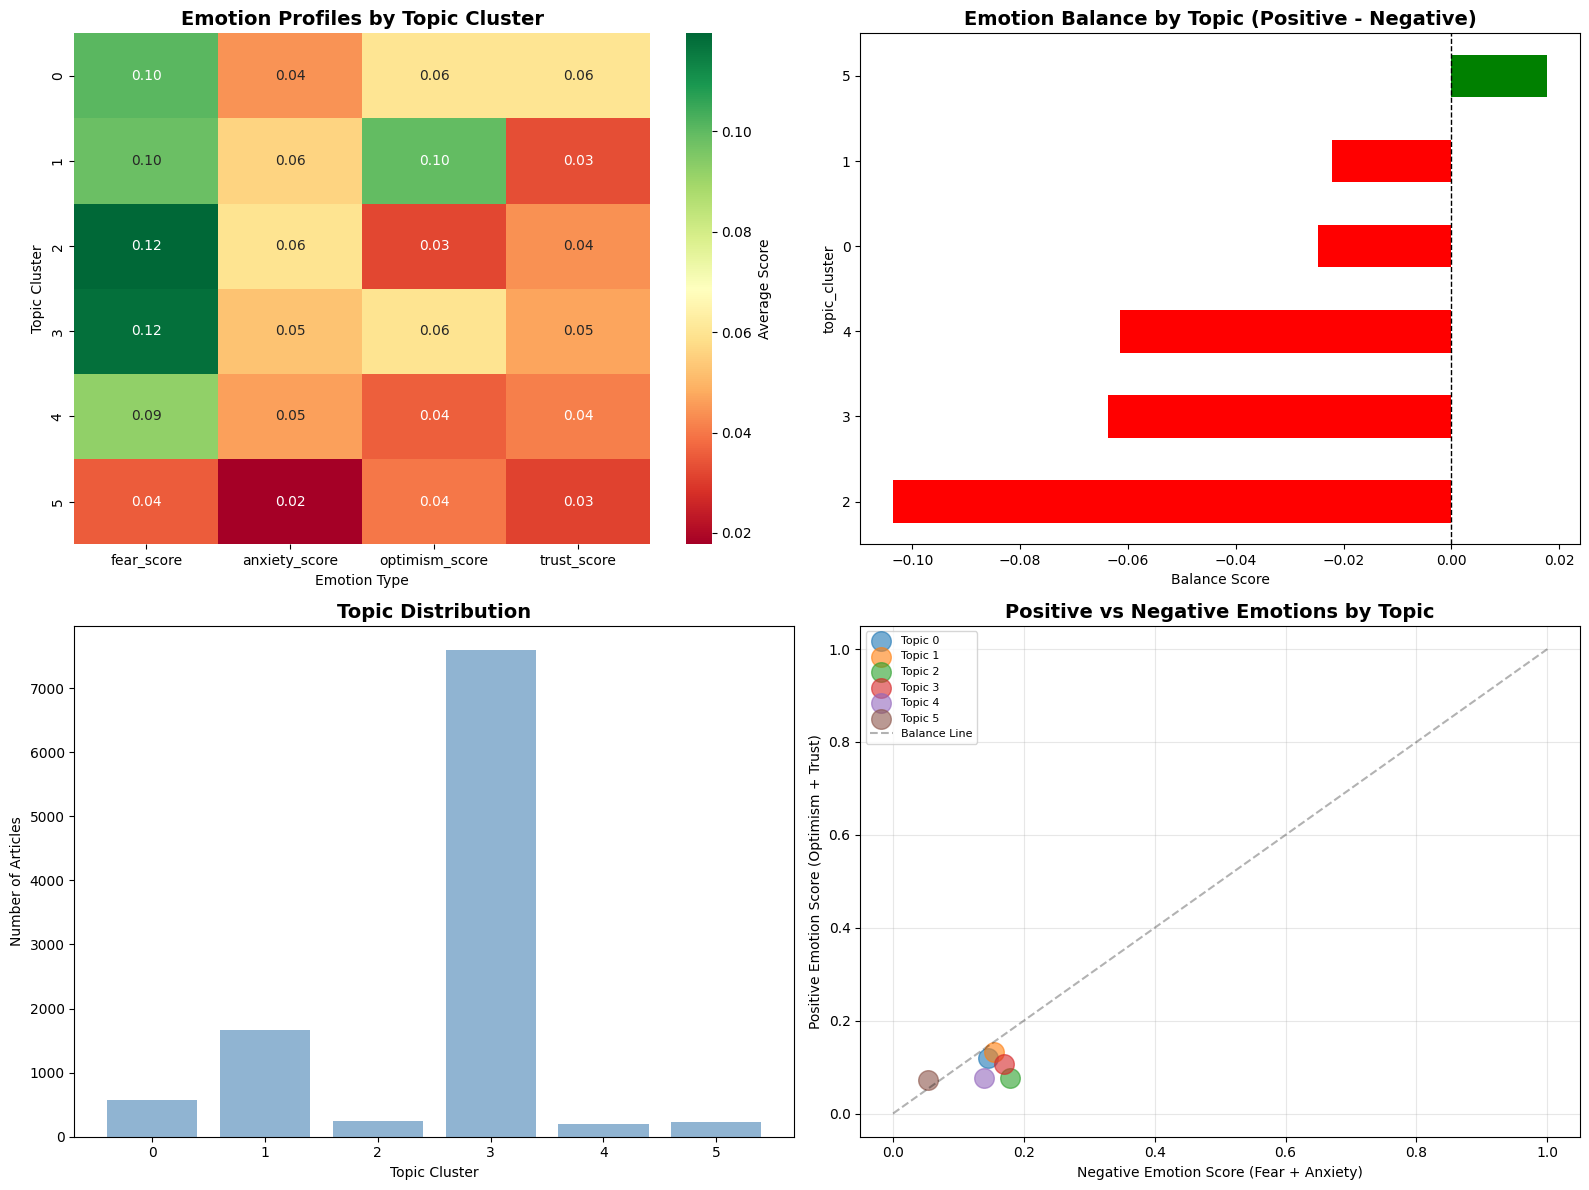


✓ Saved: analysis_outputs/emotion_topic_profiles.png


In [90]:
import seaborn as sns

print("\n" + "=" * 80)
print("INTEGRATED ANALYSIS: EMOTION PROFILES BY TOPIC")
print("=" * 80)

# Merge topic clusters into your emotion DataFrame
emotion['topic_cluster'] = df['topic_cluster']

# Calculate emotion scores by topic
emotion_by_topic = emotion.groupby('topic_cluster')[
    ['fear_score', 'anxiety_score', 'optimism_score', 'trust_score']
].mean()

print("\nAverage emotion scores by topic:")
print(emotion_by_topic.round(3))

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Heatmap of emotions by topic
ax = axes[0, 0]
sns.heatmap(emotion_by_topic, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax,
            cbar_kws={'label': 'Average Score'})
ax.set_title('Emotion Profiles by Topic Cluster', fontsize=14, fontweight='bold')
ax.set_xlabel('Emotion Type')
ax.set_ylabel('Topic Cluster')

# Plot 2: Emotion balance by topic
ax = axes[0, 1]
emotion['emotion_balance'] = (emotion['optimism_score'] + emotion['trust_score']) - \
                              (emotion['fear_score'] + emotion['anxiety_score'])
emotion_balance_by_topic = emotion.groupby('topic_cluster')['emotion_balance'].mean().sort_values()
colors = ['red' if x < 0 else 'green' for x in emotion_balance_by_topic.values]
emotion_balance_by_topic.plot(kind='barh', ax=ax, color=colors)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_title('Emotion Balance by Topic (Positive - Negative)', fontsize=14, fontweight='bold')
ax.set_xlabel('Balance Score')

# Plot 3: Topic sizes
ax = axes[1, 0]
topic_sizes = emotion['topic_cluster'].value_counts().sort_index()
bars = ax.bar(topic_sizes.index, topic_sizes.values, color='steelblue', alpha=0.6)
ax.set_xlabel('Topic Cluster')
ax.set_ylabel('Number of Articles')
ax.set_title('Topic Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(range(n_clusters))

# Plot 4: Scatter - Positive vs Negative by topic
ax = axes[1, 1]
for topic in range(n_clusters):
    topic_data = emotion_by_topic.loc[topic]
    neg_score = topic_data['fear_score'] + topic_data['anxiety_score']
    pos_score = topic_data['optimism_score'] + topic_data['trust_score']
    ax.scatter(neg_score, pos_score, s=200, alpha=0.6, label=f'Topic {topic}')

max_val = max(emotion_by_topic.values.max(), 1)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Balance Line')
ax.set_xlabel('Negative Emotion Score (Fear + Anxiety)')
ax.set_ylabel('Positive Emotion Score (Optimism + Trust)')
ax.set_title('Positive vs Negative Emotions by Topic', fontsize=14, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/emotion_topic_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR}/emotion_topic_profiles.png")



Domain Distribution by Topic: Shows which content domains (work, education, health, etc.) are most associated with each topic cluster.

**Top-Left: Emotion Heatmap**

* Topic 2 & 3 have the highest fear (dark green = 0.12)
* Topic 5 has the lowest anxiety (dark red = 0.02) and lowest fear (0.04)
* Topic 1 has relatively high optimism (0.10) and low trust (0.03)
* Most topics show fear > optimism, except Topic 5


**Top-Right: Emotion Balance**

* ALL topics except Topic 5 have negative emotion balance (red bars)
* This means negative emotions (fear + anxiety) outweigh positive ones (optimism + trust)
* Topic 5 is the ONLY positive topic (green bar = +0.02)

**Bottom-Left: Topic Distribution**

* Topic 3 dominates with ~7,600 articles (72% of dataset!)
* Topics 0, 1, 2, 4, 5 are much smaller (200-1,700 articles each)
* This is very imbalanced - one topic overwhelms the dataset

**Bottom-Right: Positive vs Negative Scatter**

* All topics cluster in the lower-left quadrant = low positive, low-to-moderate negative
* Topic 5 (purple) is closest to the balance line but still slightly below
* Most topics have more negative than positive emotional content

Interpretation: The dataset is dominated by one massive topic (Topic 3) about work/jobs, and most topics lean negative emotionally.

DOMAIN DISTRIBUTION BY TOPIC


DOMAIN DISTRIBUTION BY TOPIC

Domain prevalence by topic (proportion of articles):
               is_sentiment  is_emotion  is_human_roles  is_behavior  \
topic_cluster                                                          
0                     0.146       0.071           0.115        0.109   
1                     0.105       0.037           0.092        0.107   
2                     0.116       0.036           0.159        0.116   
3                     0.148       0.056           0.128        0.157   
4                     0.087       0.062           0.046        0.046   
5                     0.040       0.009           0.080        0.027   

               is_cognitive  is_creativity  is_relationships  is_work  \
topic_cluster                                                           
0                     0.062          0.069             0.076    0.219   
1                     0.160          0.082             0.037    0.204   
2                     0.060          0.060     

<Figure size 1400x800 with 0 Axes>

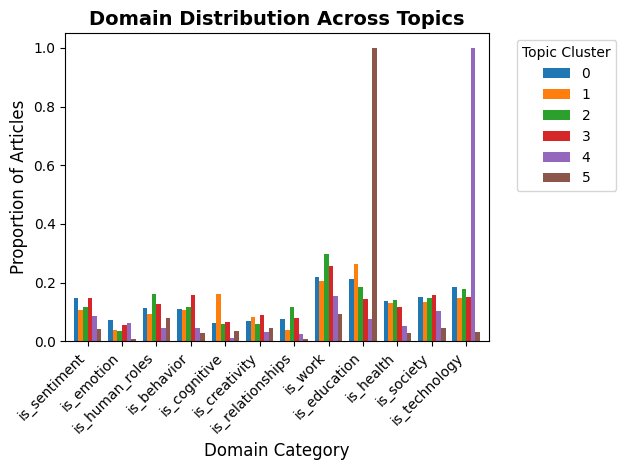


✓ Saved: analysis_outputs/domain_topic_distribution.png


In [91]:
print("\n" + "=" * 80)
print("DOMAIN DISTRIBUTION BY TOPIC")
print("=" * 80)

# Use your existing domain columns
domain_cols = ['is_sentiment', 'is_emotion', 'is_human_roles', 'is_behavior',
               'is_cognitive', 'is_creativity', 'is_relationships', 'is_work',
               'is_education', 'is_health', 'is_society', 'is_technology']

domain_by_topic = df.groupby('topic_cluster')[domain_cols].mean()

print("\nDomain prevalence by topic (proportion of articles):")
print(domain_by_topic.round(3))

# Visualize
plt.figure(figsize=(14, 8))
domain_by_topic.T.plot(kind='bar', width=0.8)
plt.xlabel('Domain Category', fontsize=12)
plt.ylabel('Proportion of Articles', fontsize=12)
plt.title('Domain Distribution Across Topics', fontsize=14, fontweight='bold')
plt.legend(title='Topic Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/domain_topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR}/domain_topic_distribution.png")



* Topic 5 (brown) is 100% education-focused
* Topic 4 (light purple) is 100% technology-focused
* Topic 3 (dark purple) strongly associates with work/jobs domain (~0.3 proportion)
* All other topics have mixed domain associations
* Most topics show presence across sentiment, emotion, behavior, relationships, and society domains

Interpretation:

* Topics 4 & 5 are pure/specialized (single-domain)
* Topics 0-3 are mixed/general (multi-domain)
* Work/economy and education are strong differentiators

Topic-Specific Temporal Analysis: Creates separate time-series plots for each topic, showing how emotions evolve differently across different AI news themes over the months.

Comprehensive Topic Summary: Generates a complete summary table for each topic including article count, percentage, top keywords, average emotions, emotion balance (negative vs positive), and dominant content domain.


TOPIC-SPECIFIC TEMPORAL ANALYSIS


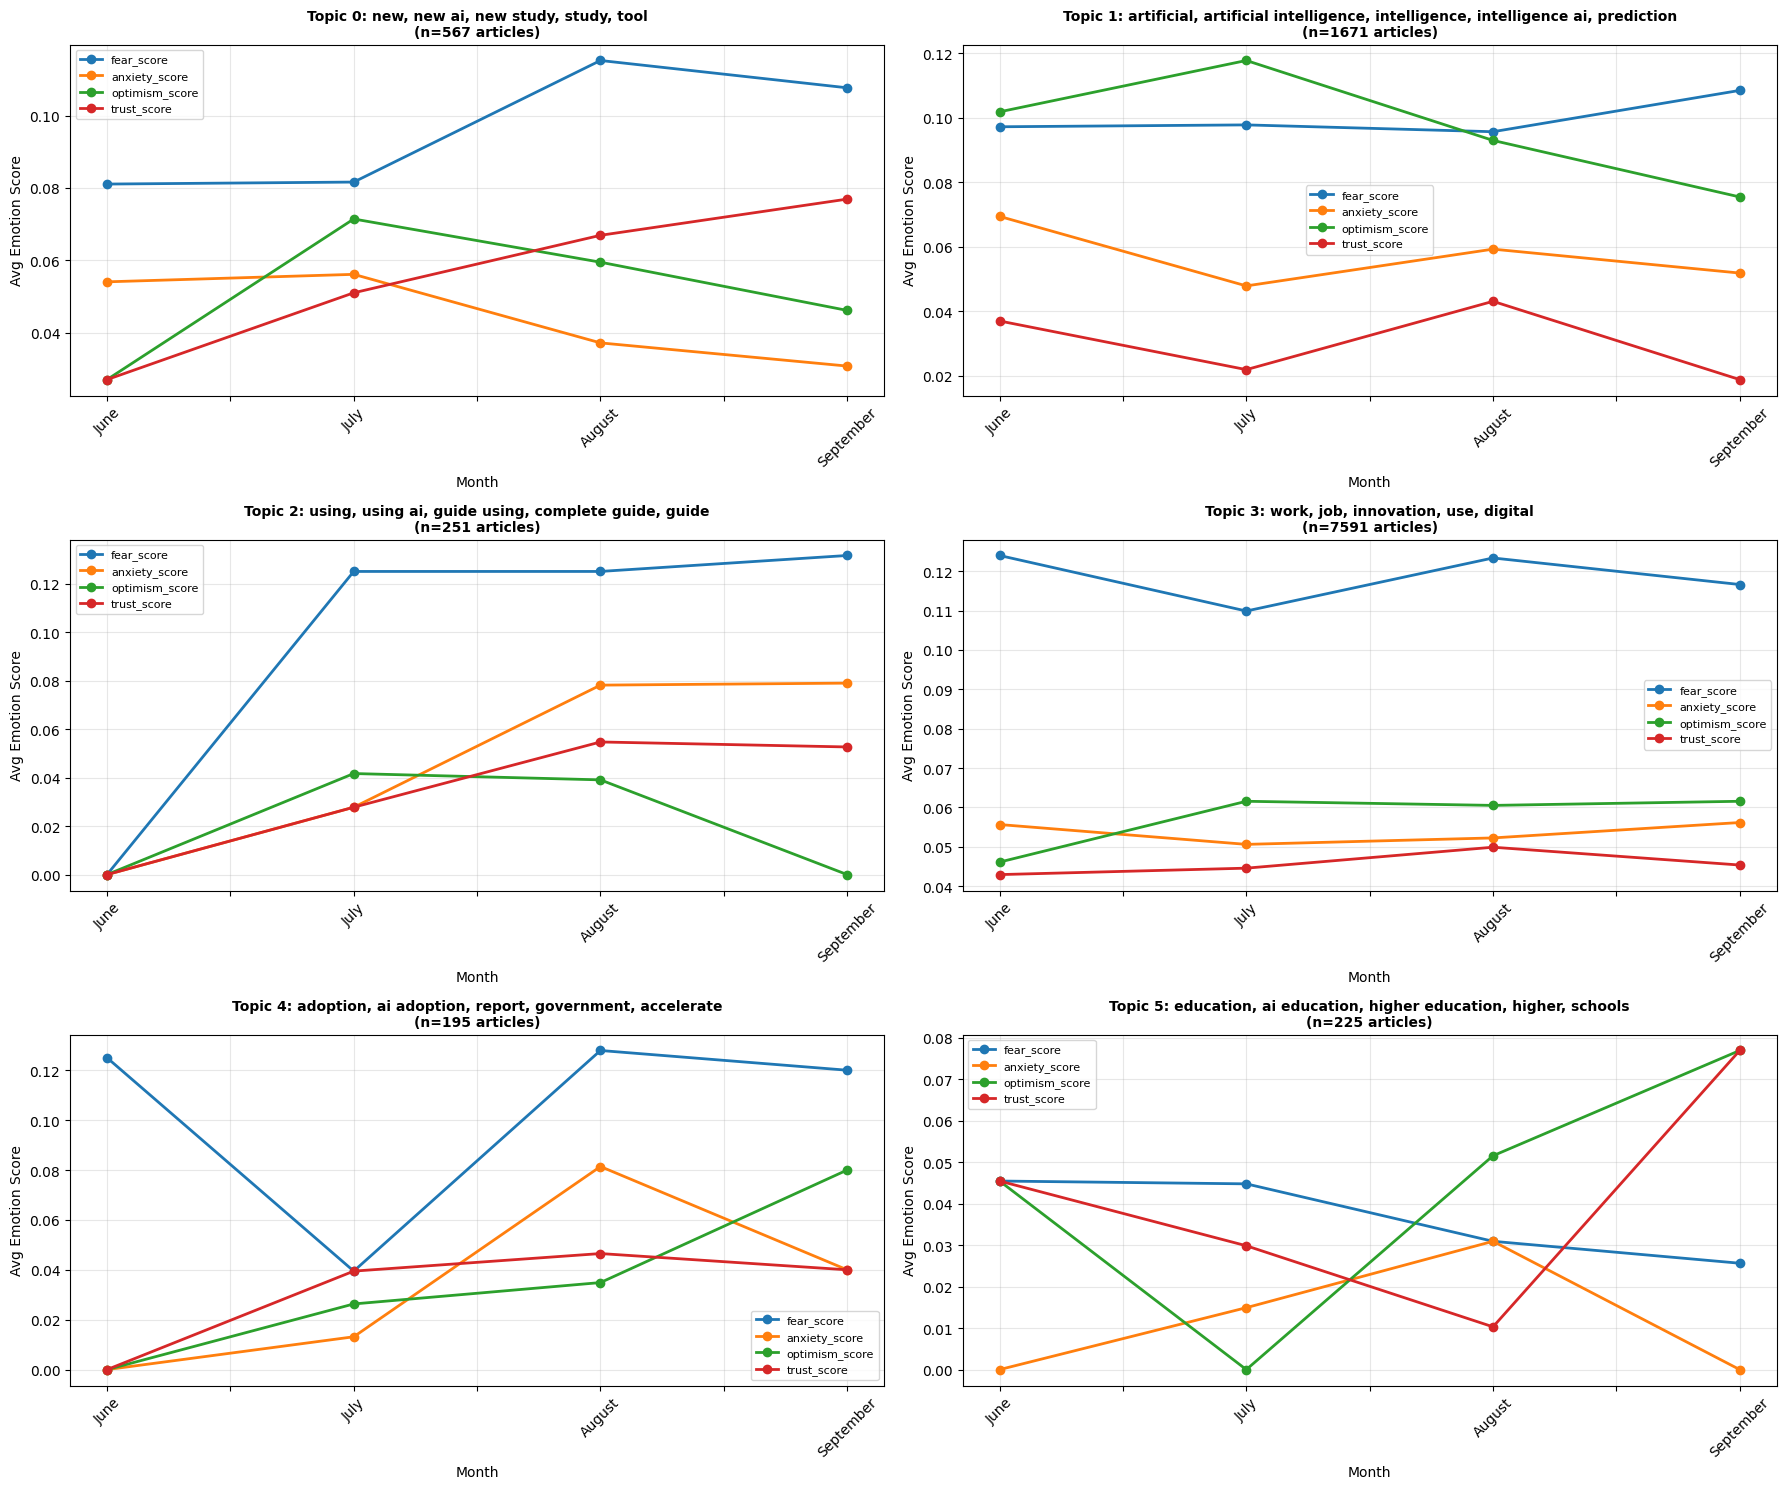


✓ Saved: analysis_outputs/topic_specific_temporal.png


In [92]:
print("\n" + "=" * 80)
print("TOPIC-SPECIFIC TEMPORAL ANALYSIS")
print("=" * 80)

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Create figure with subplots for each topic
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
axes = axes.flatten()

for topic_id in range(n_clusters):
    ax = axes[topic_id]

    # Filter emotion data for this topic
    topic_emotion = emotion[emotion['topic_cluster'] == topic_id]

    # Get emotion trends by month
    topic_emotion_month = topic_emotion.groupby('month')[
        ['fear_score', 'anxiety_score', 'optimism_score', 'trust_score']
    ].mean().reindex(month_order)

    # Plot
    topic_emotion_month.plot(ax=ax, marker='o', linewidth=2)

    # Add title with keywords
    keywords_str = ', '.join(topic_keywords[topic_id][:5])
    ax.set_title(f'Topic {topic_id}: {keywords_str}\n(n={len(topic_emotion)} articles)',
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Avg Emotion Score')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/topic_specific_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR}/topic_specific_temporal.png")



Topic 0: "new, new ai, new study, study, tool" (Research/Innovation)

* Fear increases dramatically in August
* Optimism peaks in July, then declines
* Trust gradually increases over time
* Pattern: Growing concern about new AI developments

Topic 1: "artificial intelligence, prediction" (General AI)

* Optimism highest in July, then drops sharply
* Fear stays consistent ~0.10
* Trust drops significantly by September
Pattern: Declining optimism about AI's promises

Topic 2: "using, using ai, guide using, complete guide" (AI Usage/Tutorials)

* Fear skyrockets starting in July (0.00 → 0.13!)
* All emotions increase dramatically
* Pattern: Growing concerns about AI usage/implementation

Topic 3: "work, job, innovation, digital" (Work/Economy) - 72% of articles!

* Consistently high fear (~0.12) throughout
* Low optimism (~0.06)
* Stable over time
* Pattern: Persistent job displacement fears

Topic 4: "adoption, ai adoption, report, government" (Policy/Regulation)

* Fear drops in July, then surges back
* Volatile emotions, especially anxiety in August
* Pattern: Uncertainty about AI governance

Topic 5: "education, ai education, higher education, schools" (Education)

* Complete reversal! Fear drops, optimism/trust surge in September
* Only topic with positive trend
* Pattern: Growing optimism about AI in education

In [93]:
print("\n" + "=" * 80)
print("COMPREHENSIVE TOPIC SUMMARY")
print("=" * 80)

domain_map = {
    'is_sentiment': 'Sentiment (Positive / Negative Feelings)',
    'is_emotion': 'Emotion, Motivation & Well-being',
    'is_human_roles': 'Human Roles',
    'is_behavior': 'Routine, Lifestyle & Behavior',
    'is_cognitive': 'Cognitive & Decision-Making',
    'is_creativity': 'Creativity, Expression & Identity',
    'is_relationships': 'Social Interaction & Relationships',
    'is_work': 'Work, Jobs & Economy',
    'is_education': 'Learning, Knowledge & Education',
    'is_health': 'Health, Safety & Risk',
    'is_society': 'Society, Ethics & Culture',
    'is_technology': 'Technology & Interaction'
}

for topic_id in range(n_clusters):
    print(f"\n{'=' * 80}")
    print(f"TOPIC {topic_id}")
    print(f"{'=' * 80}")

    topic_data = df[df['topic_cluster'] == topic_id]
    topic_emotion = emotion[emotion['topic_cluster'] == topic_id]

    # Basic stats
    print(f"\nSIZE: {len(topic_data)} articles ({len(topic_data)/len(df)*100:.1f}%)")

    # Keywords
    print(f"\n TOP KEYWORDS:")
    print(f"   {', '.join(topic_keywords[topic_id][:10])}")

    # Emotion profile
    print(f"\n EMOTION PROFILE:")
    emotions = topic_emotion[['fear_score', 'anxiety_score', 'optimism_score', 'trust_score']].mean()
    for emotion_name, score in emotions.items():
        print(f"   {emotion_name:20} {score:.3f}")

    balance = topic_emotion['emotion_balance'].mean()
    sentiment = "POSITIVE ✓" if balance > 0 else "NEGATIVE ✗"
    print(f"   Balance:             {balance:.3f} ({sentiment})")

    # Top domains
    print(f"\n  TOP DOMAINS:")
    domain_scores = topic_data[domain_cols].mean().sort_values(ascending=False).head(3)
    for domain, score in domain_scores.items():
        domain_name = domain_map[domain]
        print(f"   {domain_name:45} {score:.3f}")

    # Sample headlines
    print(f"\nSAMPLE HEADLINES:")
    samples = topic_data.sample(min(3, len(topic_data)))['title'].values
    for i, headline in enumerate(samples, 1):
        print(f"   {i}. {headline}")





COMPREHENSIVE TOPIC SUMMARY

TOPIC 0

SIZE: 567 articles (5.4%)

 TOP KEYWORDS:
   new, new ai, new study, study, tool, tools, ai tool, use, ai new, report

 EMOTION PROFILE:
   fear_score           0.101
   anxiety_score        0.044
   optimism_score       0.060
   trust_score          0.060
   Balance:             -0.025 (NEGATIVE ✗)

  TOP DOMAINS:
   Work, Jobs & Economy                          0.219
   Learning, Knowledge & Education               0.212
   Technology & Interaction                      0.183

SAMPLE HEADLINES:
   1. Humans still beat AI at one key creative task, new study finds
   2. Scale AI faces a new investigation into how it treats its workforce
   3. Databricks, Perplexity co-founder pledges $100M on new fund for AI researchers

TOPIC 1

SIZE: 1671 articles (15.9%)

 TOP KEYWORDS:
   artificial, artificial intelligence, intelligence, intelligence ai, prediction, technology, university, use, education, analysis

 EMOTION PROFILE:
   fear_score           0.0

Export Results Optional I think...


In [94]:

print("\n" + "=" * 80)
print("EXPORTING RESULTS")
print("=" * 80)

# Add topic cluster to main dataframe if not already there
if 'topic_cluster' not in df.columns:
    df['topic_cluster'] = emotion['topic_cluster']

# Save enhanced dataframe
output_path = f'{OUTPUT_DIR}/ai_news_analysis_with_topics.csv'
df.to_csv(output_path, index=False)
print(f"\n✓ Enhanced dataset saved to: {output_path}")

# Create topic summary table
summary_data = []
for topic_id in range(n_clusters):
    topic_data = df[df['topic_cluster'] == topic_id]
    topic_emotion = emotion[emotion['topic_cluster'] == topic_id]

    summary_data.append({
        'topic_id': topic_id,
        'n_articles': len(topic_data),
        'percentage': len(topic_data) / len(df) * 100,
        'top_keywords': ', '.join(topic_keywords[topic_id][:5]),
        'avg_fear': topic_emotion['fear_score'].mean(),
        'avg_anxiety': topic_emotion['anxiety_score'].mean(),
        'avg_optimism': topic_emotion['optimism_score'].mean(),
        'avg_trust': topic_emotion['trust_score'].mean(),
        'emotion_balance': topic_emotion['emotion_balance'].mean(),
        'top_domain': domain_by_topic.loc[topic_id].idxmax(),
        'top_domain_score': domain_by_topic.loc[topic_id].max()
    })

summary_df = pd.DataFrame(summary_data)
summary_path = f'{OUTPUT_DIR}/topic_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f"✓ Topic summary saved to: {summary_path}")

print("\n" + "=" * 80)
print("✅ ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\nAll outputs in: {OUTPUT_DIR}/")
print(f"\nFiles created:")
print(f"  1. elbow_curve.png")
print(f"  2. emotion_topic_profiles.png")
print(f"  3. domain_topic_distribution.png")
print(f"  4. topic_specific_temporal.png")
print(f"  5. ai_news_analysis_with_topics.csv")
print(f"  6. topic_summary.csv")

# Display summary
print("\n" + "=" * 80)
print("TOPIC SUMMARY TABLE")
print("=" * 80)
display(summary_df)



EXPORTING RESULTS

✓ Enhanced dataset saved to: analysis_outputs/ai_news_analysis_with_topics.csv
✓ Topic summary saved to: analysis_outputs/topic_summary.csv

✅ ANALYSIS COMPLETE!

All outputs in: analysis_outputs/

Files created:
  1. elbow_curve.png
  2. emotion_topic_profiles.png
  3. domain_topic_distribution.png
  4. topic_specific_temporal.png
  5. ai_news_analysis_with_topics.csv
  6. topic_summary.csv

TOPIC SUMMARY TABLE


,topic_id,n_articles,percentage,top_keywords,avg_fear,avg_anxiety,avg_optimism,avg_trust,emotion_balance,top_domain,top_domain_score
0,0,567,5.400000,"new, new ai, new study, study, tool",0.100529,0.044092,0.059965,0.059965,-0.024691,is_work,0.218695
1,1,1671,15.914286,"artificial, artificial intelligence, intellige...",0.098145,0.056254,0.099342,0.032914,-0.022142,is_education,0.262118
2,2,251,2.390476,"using, using ai, guide using, complete guide, ...",0.119522,0.059761,0.031873,0.043825,-0.103586,is_work,0.298805
3,3,7591,72.295238,"work, job, innovation, use, digital",0.117903,0.052431,0.059808,0.046898,-0.063628,is_work,0.254907
4,4,195,1.857143,"adoption, ai adoption, report, government, acc...",0.092308,0.046154,0.035897,0.041026,-0.061538,is_technology,1.000000
5,5,225,2.142857,"education, ai education, higher education, hig...",0.035556,0.017778,0.040000,0.031111,0.017778,is_education,1.000000


Agentic Reasoning Workflow (Dataset C)
Given structured evidence from media coverage, synthesize how AI's impact on human behavior is framed by AI systems themselves:

Step 1: Build Evidence Pack

In [119]:
# 1) Monthly time key (sortable)
df['month_date'] = df['date'].dt.to_period('M').dt.to_timestamp()

# 2) Ensure emotion has the same key (only if emotion aligns row-wise with df)
emotion = emotion.copy()
emotion['month_date'] = df['month_date']

# 3) Core time evidence
emotion_by_month_date = (
    emotion.groupby('month_date')[['fear_score','anxiety_score','optimism_score','trust_score']]
          .mean()
          .sort_index()
)

net_by_month = (
    emotion_by_month_date['optimism_score'] + emotion_by_month_date['trust_score']
    - emotion_by_month_date['fear_score'] - emotion_by_month_date['anxiety_score']
)

topic_share_by_month = (
    emotion.groupby(['month_date','topic_cluster'])
          .size()
          .unstack(fill_value=0)
          .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
          .sort_index()
)

emotion_by_topic_month_date = (
    emotion.groupby(['topic_cluster','month_date'])[['fear_score','anxiety_score','optimism_score','trust_score']]
          .mean()
          .round(4)
          .to_dict()
)

emotion_by_topic_month_date_df = (
    emotion.groupby(['topic_cluster','month_date'])[['fear_score','anxiety_score','optimism_score','trust_score']]
          .mean()
          .sort_index()
)


emotion['net_emotion'] = (
    emotion['optimism_score'] + emotion['trust_score']
    - emotion['fear_score'] - emotion['anxiety_score']
)

fear_examples = df.loc[emotion['net_emotion'].nsmallest(6).index, 'title'].tolist()
optimism_examples = df.loc[emotion['net_emotion'].nlargest(6).index, 'title'].tolist()


evidence_pack = {
    "topic_summary_table": summary_df.to_dict(orient="records"),
    "emotion_by_topic": emotion_by_topic.round(4).to_dict(),
    "emotion_balance_by_topic": emotion_balance_by_topic.round(4).to_dict(),
    "topic_sizes": topic_sizes.to_dict(),
    "topic_keywords": topic_keywords,
    "domain_by_topic": domain_by_topic.round(4).to_dict(),
    "emotion_by_topic_month_date" : emotion_by_topic_month_date,
    "emotion_by_month_date": emotion_by_month_date.round(4).to_dict(),
    "net_by_month": net_by_month.round(4).to_dict(),
    "fear_examples": fear_examples,
    "optimism_examples" : optimism_examples,
    "topic_share_by_month": topic_share_by_month.round(4).to_dict()
}

#run the evidence pack build
evidence_pack.keys()



,count
1.0,4


Load Open-Weights Model - Phi-3.5-mini-instruct

In [109]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "microsoft/phi-3.5-mini-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"
)

gen_config = {
    "max_new_tokens": 400,
    "temperature": 0.2,
    "top_p": 0.9,
    "do_sample": False
}



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]